In [1]:
import numpy as np
import os
import random
import torch

from torch.utils.data import DataLoader, random_split

from Callbacks import EarlyStopping
from TransferLearningModel import TransferLearningModel
from utils import DICOMFineDataset, TransformDataset, TransformDatasetBalanced, find_overlapping_images

In [2]:
data_augmentation = False

In [3]:
BASE_DIR = "C:/Users/Dominik Hahn/OneDrive/Studium/Master/Masterarbeit/Daten/nodule"
# BASE_DIR = "C:/Users/domin/OneDrive/Studium/Master/Masterarbeit/Daten"
seed = 41
batch_size = 32
classes = ["A", "B", "E", "G"]
train_ratio = 0.6

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

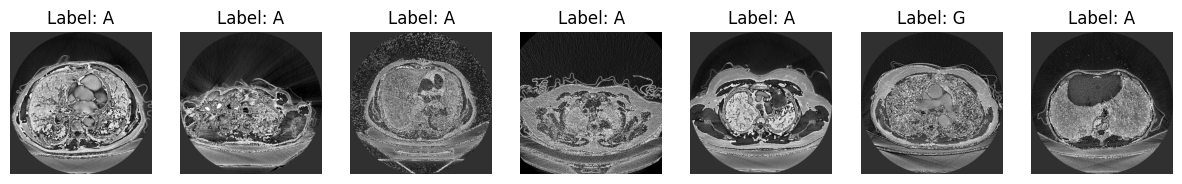

In [4]:
classes_dict = {value: index for index, value in enumerate(classes)}
dataset = DICOMFineDataset(root_dir=BASE_DIR, classes=classes_dict)
# dataset = DICOMFineDataset(root_dir=BASE_DIR, classes=classes)
dataset.visualize_images(num_images=7)

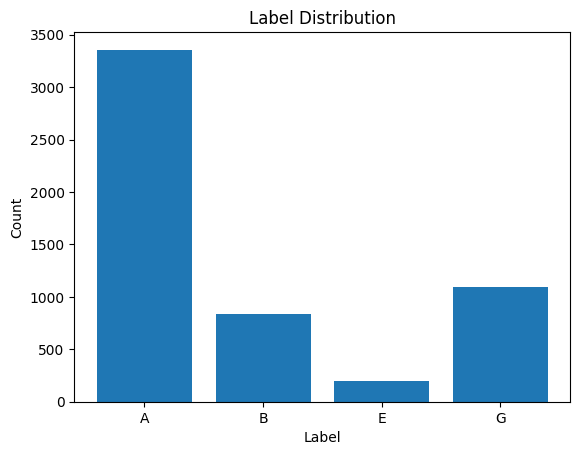

In [5]:
dataset.display_label_distribution()

In [6]:
train_size = int(train_ratio * len(dataset))
val_size = int(((1-train_ratio)/2) * len(dataset)) 
test_size = len(dataset) - train_size - val_size

print(f"Train size: {train_size} --- Validation size: {val_size} --- Test size: {test_size}")

Train size: 3295 --- Validation size: 1098 --- Test size: 1100


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.109686..2.403777].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9442278..2.4494572].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0692492..2.3193533].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0169291..1.8609217].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9503438..1.9828792].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8612239..2.1839235].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9610356.

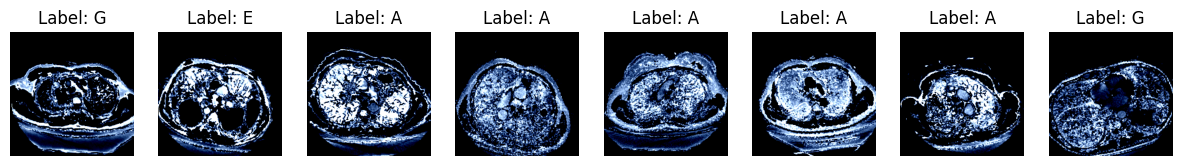

In [7]:
from utils import display_data_loader_batch
display_model = TransferLearningModel(classes, "resnet", data_augmentation=True, fine=False, scenario=1)
display_model.train_transforms, display_model.test_transforms = display_model.get_transforms()
train_indices, val_indices, test_indices = random_split(dataset, [train_size, val_size, test_size])
train_dataset = TransformDataset(torch.utils.data.Subset(dataset, train_indices.indices), transform=display_model.train_transforms)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
display_data_loader_batch(train_loader, classes)

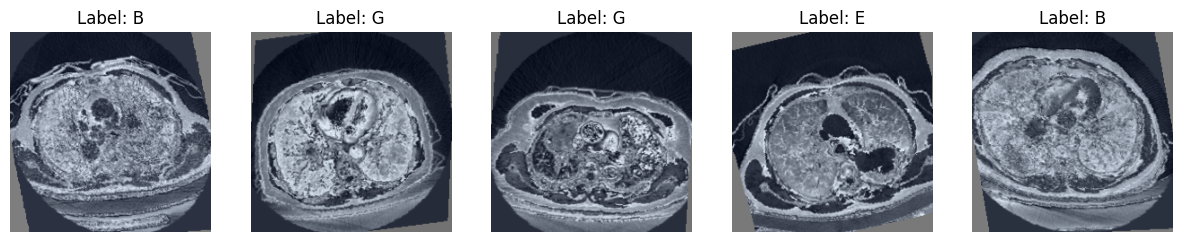

In [8]:

train_dataset = TransformDatasetBalanced(torch.utils.data.Subset(dataset, train_indices.indices), classes=classes_dict, transform=display_model.train_transforms)
train_dataset.visualize_images()

In [11]:
train_indices, val_indices, test_indices = random_split(dataset, [train_size, val_size, test_size])

# Apply specific transforms to each subset
train_dataset = TransformDataset(torch.utils.data.Subset(dataset, train_indices.indices), transform=display_model.train_transforms)
val_dataset = TransformDataset(torch.utils.data.Subset(dataset, val_indices.indices), transform=display_model.test_transforms)
test_dataset = TransformDataset(torch.utils.data.Subset(dataset, test_indices.indices), transform=display_model.test_transforms)

find_overlapping_images(train_dataset, test_dataset)

Found 0 overlapping images


In [12]:
model_names = ["resnet", "densenet", "inception", "efficientnet", "efficientnet2", "efficientnet3", "vit"]
best_val_loss = float('inf')
best_model = None

for model_name in model_names:
    print(f"Processing model: {model_name}")
    current_model = TransferLearningModel(classes, model_name, data_augmentation=data_augmentation, fine=True)

    # Ensure transforms are correctly applied based on model requirements
    current_model.train_transforms, current_model.test_transforms = current_model.get_transforms()
    train_indices, val_indices, test_indices = random_split(dataset, [train_size, val_size, test_size])

    # Apply specific transforms to each subset
    train_dataset = TransformDatasetBalanced(torch.utils.data.Subset(dataset, train_indices.indices), classes=classes_dict, transform=current_model.train_transforms)
    val_dataset = TransformDatasetBalanced(torch.utils.data.Subset(dataset, val_indices.indices), classes=classes_dict, transform=current_model.test_transforms)
    test_dataset = TransformDataset(torch.utils.data.Subset(dataset, test_indices.indices), transform=current_model.test_transforms)

    print(f"Train size upsampled: {len(train_dataset)} --- Validation size upsampled: {len(val_dataset)} --- Test size upsampled: {len(test_dataset)}")

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Initialize early stopping
    early_stopping = EarlyStopping(patience=10)

    # Train the current model
    current_model.train(train_loader, val_loader, early_stopping, epochs=50)

    # Track the best model based on validation loss
    final_val_loss = current_model.val_losses[-1]
    if final_val_loss < best_val_loss:
        best_val_loss = final_val_loss
        best_model = current_model

print(f"The best model is {best_model.model_name} with a validation loss of {best_val_loss:.4f}")

Processing model: resnet
Train size upsampled: 8044 --- Validation size upsampled: 2684 --- Test size upsampled: 1100
Weights already exist, start from best previous values.
Epoch 1/50 ----- Loss: 0.3013, Accuracy: 88.91% ----- Validation Loss: 0.2520, Validation Accuracy: 92.14%
Epoch 2/50 ----- Loss: 0.2691, Accuracy: 90.39% ----- Validation Loss: 0.2586, Validation Accuracy: 92.06%
Epoch 3/50 ----- Loss: 0.2656, Accuracy: 90.39% ----- Validation Loss: 0.2533, Validation Accuracy: 91.06%
Early stopping triggered
Processing model: densenet
Train size upsampled: 8184 --- Validation size upsampled: 2600 --- Test size upsampled: 1100
Weights already exist, start from best previous values.
Epoch 1/50 ----- Loss: 0.3499, Accuracy: 86.82% ----- Validation Loss: 0.2657, Validation Accuracy: 90.42%
Epoch 2/50 ----- Loss: 0.3175, Accuracy: 87.74% ----- Validation Loss: 0.2898, Validation Accuracy: 89.23%
Epoch 3/50 ----- Loss: 0.3066, Accuracy: 88.39% ----- Validation Loss: 0.2725, Validation 

c:\Users\Dominik Hahn\Documents\GitHub\Masterarbeit\.venv\lib\site-packages\torch\nn\functional.py:5560: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


Epoch 1/50 ----- Loss: 0.2099, Accuracy: 93.03% ----- Validation Loss: 0.2633, Validation Accuracy: 90.17%
Epoch 2/50 ----- Loss: 0.1811, Accuracy: 94.50% ----- Validation Loss: 0.2570, Validation Accuracy: 89.69%
Epoch 3/50 ----- Loss: 0.1695, Accuracy: 94.87% ----- Validation Loss: 0.2644, Validation Accuracy: 89.58%
Epoch 4/50 ----- Loss: 0.1623, Accuracy: 95.10% ----- Validation Loss: 0.2714, Validation Accuracy: 88.41%
Early stopping triggered
The best model is efficientnet2 with a validation loss of 0.0038


Best model: efficientnet2


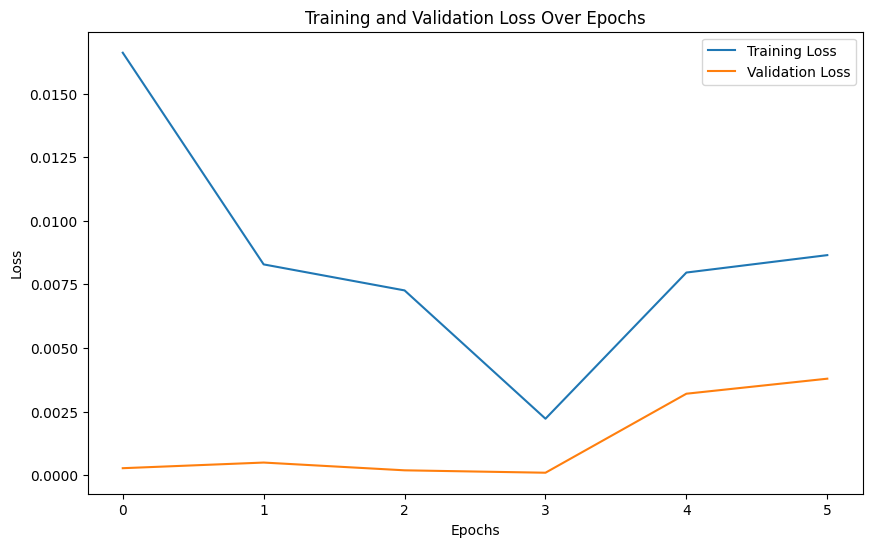

In [13]:
print(f"Best model: {best_model.model_name}")
best_model.plot_loss()

Best model: efficientnet2
9.650296035814042e-05
Evaluation Accuracy on unseen data: 100.0


<Figure size 1000x800 with 0 Axes>

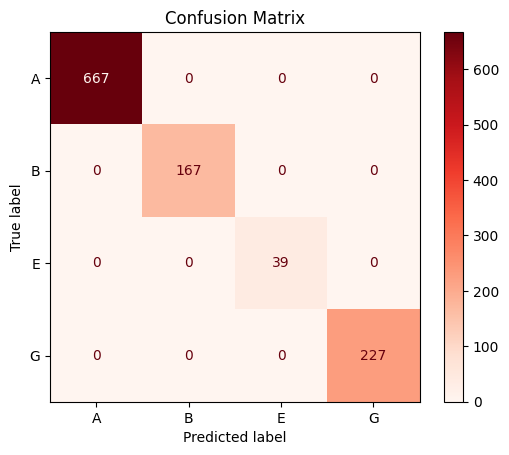

In [18]:
print(f"Best model: {best_model.model_name}")
checkpoint = torch.load(f"weights/fine/{best_model.model_name}.pt", weights_only=False)
best_model.model.load_state_dict(checkpoint['model_state_dict'])
loss = checkpoint["loss"]
print(loss)
best_model.evaluate(test_loader)

0.2519984575302164
Evaluation Accuracy on unseen data: 86.9090909090909


<Figure size 1000x800 with 0 Axes>

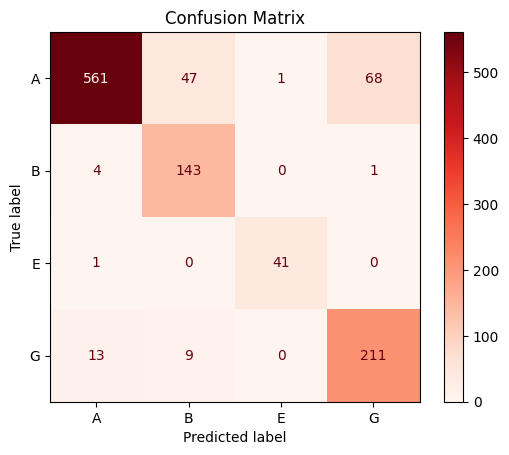

In [29]:
test_model_name = "resnet"
test_model = TransferLearningModel(classes, test_model_name, data_augmentation=False, scenario=3)
dataset = DICOMFineDataset(root_dir=BASE_DIR, classes=classes_dict)
train_size = int(train_ratio * len(dataset))
val_size = int(((1-train_ratio)/2) * len(dataset)) 
test_size = len(dataset) - train_size - val_size
# Ensure transforms are correctly applied based on model requirements
test_model.train_transforms, test_model.test_transforms = test_model.get_transforms()
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

test_dataset.dataset.transform = test_model.test_transforms

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

checkpoint = torch.load(f"weights/fine/{test_model.model_name}.pt", weights_only=False)
test_model.model.load_state_dict(checkpoint['model_state_dict'])
loss = checkpoint["loss"]
print(loss)
test_model.evaluate(test_loader)